# imports + data loading

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist
import anndata as ad
from scipy import sparse
from anndata import AnnData
from matplotlib import colors

integrated anndatas have a different index as unintegrated --> use integrated anndata (with cells and layer matrices in right order) for final annotation

In [3]:
# integrated adata
# source: "/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/merged_data/integration/dataset~integration_merged_data/method~scvi/batch~batch,label~harmonized_anno,hyperparams~d453d7a675,lineage_key~None/adata.h5ad")
adata_integrated = sc.read("/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/all_datasets_merged/final_anno_integrated.h5ad")

In [12]:
# big adata (cell barcodes in old order)
adata = sc.read("/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/all_datasets_merged/complete_merged_public_and_galapagos_integrated_scvi_neighbors_umap.h5ad")

In [32]:
neighbors_adata = sc.read("/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/merged_data/integration/dataset~integration_merged_data/method~scvi/batch~batch,label~harmonized_anno,hyperparams~d453d7a675,lineage_key~None/neighbors.h5ad")

## map doublet and augur results to integrated anndata

In [19]:
# add 'doublet_score', 'predicted_doublet', 'label', 'augur_score to integrated anndata with final anno
doublet_score_mapping = adata.obs['doublet_score'].to_dict()
predicted_doublet_mapping = adata.obs['predicted_doublet'].to_dict()
augur_score_dataset_spec_mapping = adata.obs['augur_score'].to_dict() 

In [23]:
adata_integrated.obs["doublet_score"] = adata_integrated.obs.index.map(doublet_score_mapping)
adata_integrated.obs["predicted_doublet"] = adata_integrated.obs.index.map(predicted_doublet_mapping)
adata_integrated.obs["augur_score_dataset-specific"] = adata_integrated.obs.index.map(augur_score_dataset_spec_mapping)



In [42]:
adata_integrated.obs["predicted_doublet"] = adata_integrated.obs["predicted_doublet"].astype("category")

In [10]:
adata_integrated.obs["fibrotic/control"] = adata_integrated.obs["condition"].apply(lambda x: "control" if x == "untreated" or x == "saline" else "fibrotic")
adata_integrated.obs["fibrotic/control"] = adata_integrated.obs["fibrotic/control"].astype("category")

## use connectivities and distances of neighbor anndata 

In [44]:
adata_integrated.obsp["connectivities"] = neighbors_adata.obsp["connectivities_embed"]

In [46]:
adata_integrated.obsp["distances"] = neighbors_adata.obsp["distances_embed"]  

## add umap coordinates to integrated anndata

In [11]:
scvi_umap_coord = np.load("/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/merged_data/integration/dataset~integration_merged_data/method~scvi/batch~batch,label~harmonized_anno,hyperparams~d453d7a675,lineage_key~None/umap_coordinates.npy")
adata_integrated.obsm["X_umap"] = scvi_umap_coord

# new leiden clustering

In [47]:
# leiden 
sc.tl.leiden(adata_integrated, key_added="leiden_res1", resolution=1.0)

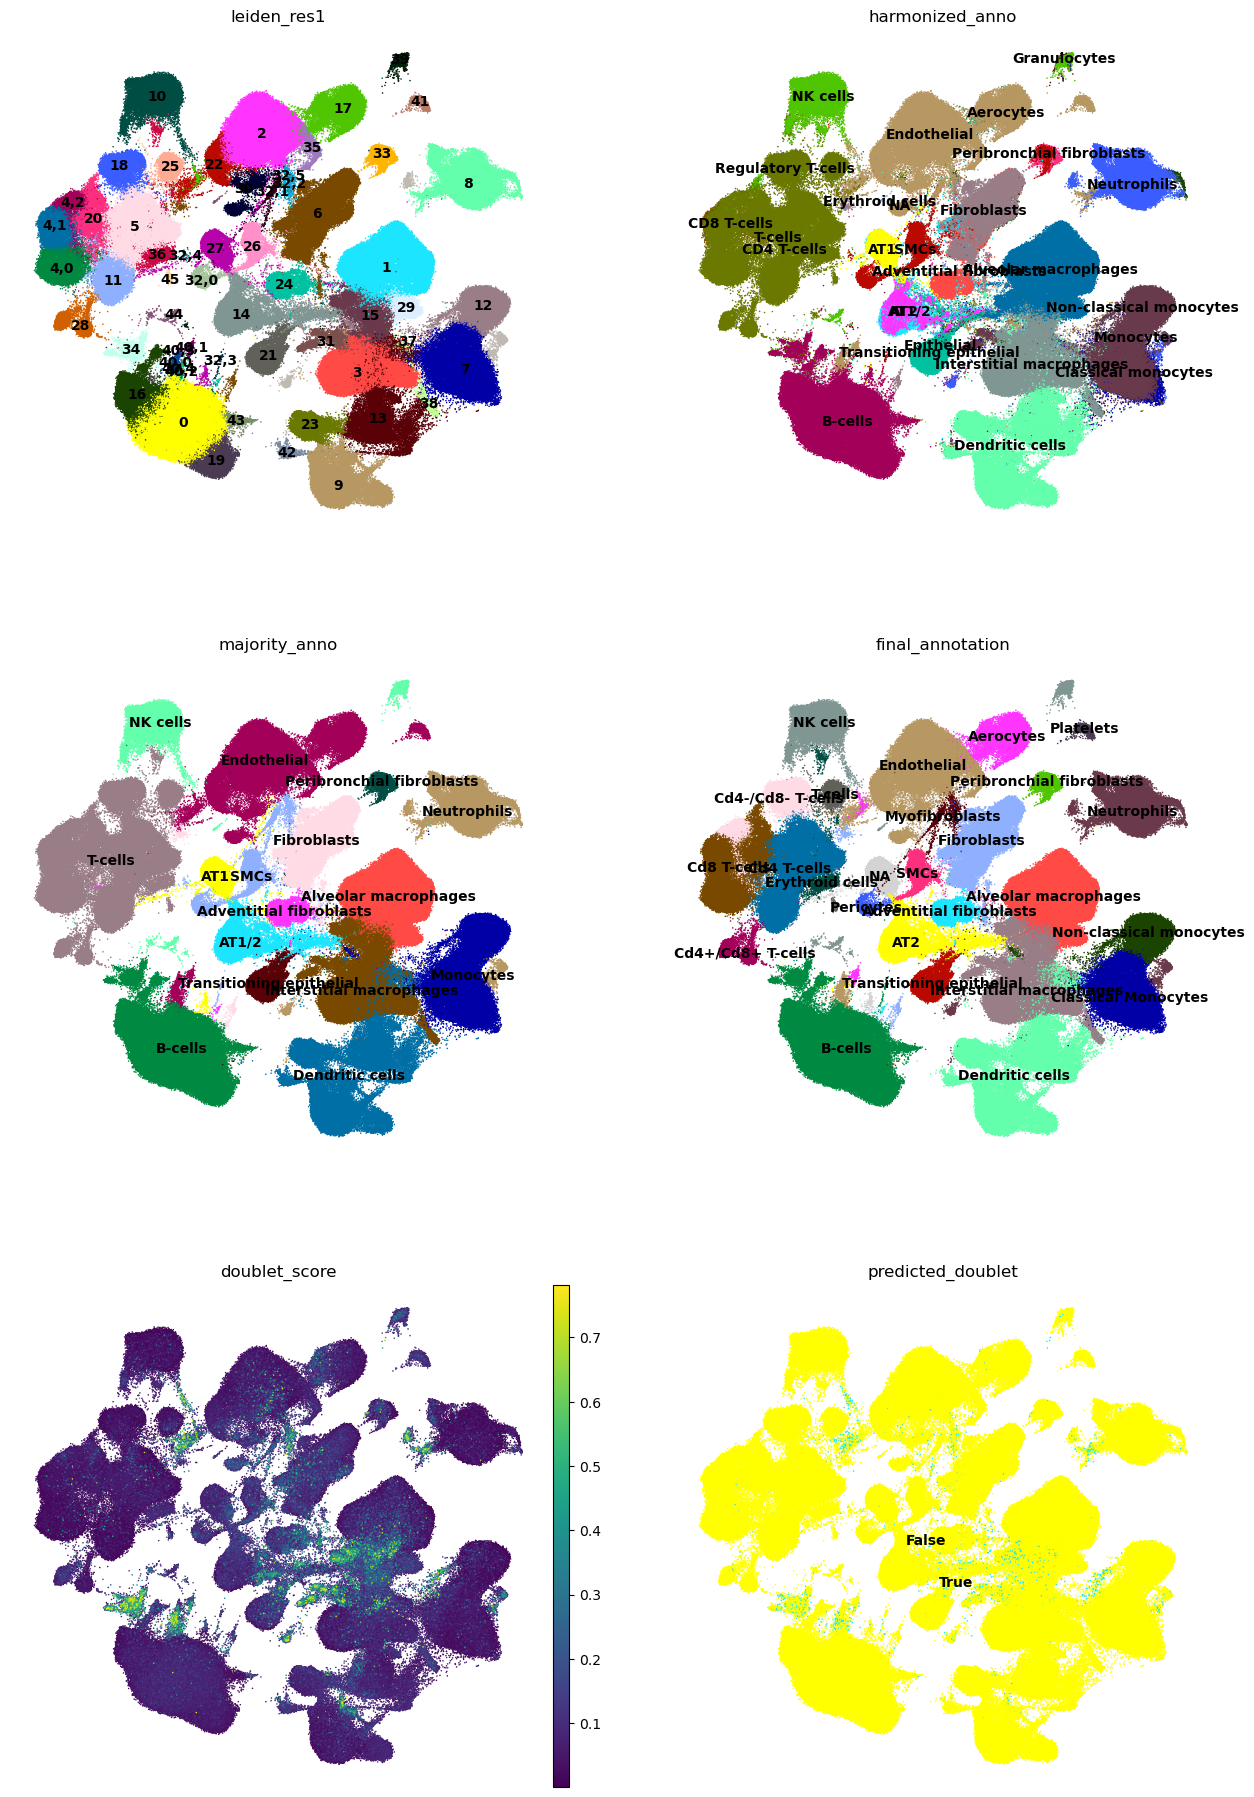

In [43]:
plt.rcParams['figure.figsize'] = (7, 7)
sc.pl.umap(
    adata_integrated,
    color=["leiden_res1", "harmonized_anno", "majority_anno", "final_annotation", "doublet_score", "predicted_doublet"],
    legend_loc="on data", 
     size=5, palette=sc.pl.palettes.default_102, frameon=False, ncols=2
)

## Subclustering

In [49]:
sc.tl.leiden(adata_integrated, restrict_to= ("leiden_res1", ['4']),  key_added="leiden_res1", resolution=0.3)

In [44]:
# save with leiden 
adata_integrated.write("/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/all_datasets_merged/final_anno_integrated.h5ad")

# Majority labels

In [ ]:
def get_majority_label(adata, transferred_label, leiden_label):
    return adata.obs[
        [transferred_label, leiden_label]
    ].value_counts().reset_index().sort_values(
        ['count', leiden_label], ascending=False,
    ).drop_duplicates(
        leiden_label,
        keep='first',
    ).set_index(leiden_label)[transferred_label].to_dict()

In [52]:
majority_labels = get_majority_label(adata_integrated, "harmonized_anno", "leiden_res1")

In [53]:
adata_integrated.obs['majority_anno'] = adata_integrated.obs['leiden_res1'].map(majority_labels)

# New annotation 

### old markers

In [29]:
old_markers = {
  "AT1": ["S100a6", "Ager", "Pdpn", "Vegfa"],
  "AT2": ["Muc1",  "Sftpd", "Cxcl15", "Lcn2"],
  "Transitioning epithelial": ["Krt8", "Krt18"],
  "Epithelial": ["Epcam", "Cdh1"],
  "Alveolar macrophages": ["Marco", "Chil3", "Fabp4", "Il18", "Ear1", "Fabp1", "Car4", "Ctsk", "Chil3", "Wfdc21", "Itgam", "Cd36", "Gpnmb", "Bhlhe41", "Atf3"],
  "Interstitial macrophages": ["Trem2", "C1qa"],
  "Classical monocytes": ["F13a1", "Ly6c2"],
  "Non-classical monocytes": ["Treml4", "Fcgr3"],
  "Dendritic cells": [ "H2-Aa"],
  "Dendritic cells pDC": ["Siglech"],#  Clec4b1 instead of Clec4c
  "Dendritic cells Ccr7-hi": ["Ccr7"],
  "CD4 T-cells": ["Cd4", "Cd3e", "Cd3d"],
  "CD8 T-cells": ["Cd8a", "Cd3d"],
  "NK cells": ["Tyrobp", "Gzma", "Nkg7"],
  "B-cells": ["Cd79a", "Cd19", "Ms4a1"],
  "Neutrophils": ["S100a8", "S100a9"],
  "Endothelial": ["Pecam1", "Ly6c1"], # Pecam1 instead of Pecam4
  "Lymphatic endothelial": ["Pdpn"],
  "Aerocytes": ["Car4", "Ednrb"],
  "Pericytes": ["Vtn", "Mcam"],
  "Lipofibroblasts": [ "Lpl", "Tcf21"],
  "Myofibroblasts": ["Cthrc1", "Spp1", "Pdgfra", "Col3a1", "Postn", "Tnc", "S100a6", "Ccl2"],
  "Alveolar fibroblast": ["Npnt", "Ces1d", "Slc7a10"],
  "Adventitial fibroblast": ["Pi16", "Dcn", "Il33", "Ccl11", "Adh7"],
  "Peribronchial fibroblasts": ["Hhip", "Aspn", "Fgf18"],
  "SMCs": ["Acta2", "Tagln", "Myh11"]
}

#['Atf4', 'Bhlhe40', 'Clec4b1', 'Clec9a', 'Cspg4', 'Jund', 'Klf9', 'Lgr5', 'Lgr6', 'Litaf', 'Plin2', 'S100a1', 'Sftpc', 'Siglecf']

In [ ]:
sc.pl.dotplot(adata_integrated, old_markers, groupby=["leiden_res1"], standard_scale="var" )

### new lung marker 

In [79]:
df = pd.read_csv('marker_genes.csv')

# Create an empty dictionary to store the mapping
cell_marker_dict = {}

# Iterate through the DataFrame and populate the dictionary
for index, row in df.iterrows():
    cell_name = row['Cell name']
    cell_marker = row['Cell marker']
    
    
    if cell_name not in cell_marker_dict:
        cell_marker_dict[cell_name] = []

    if cell_marker in adata_integrated.var.index:
        cell_marker_dict[cell_name].append(cell_marker)

#print(cell_marker_dict)
shortened_cell_marker_dict = {key: value[:6] for key, value in cell_marker_dict.items()}

del shortened_cell_marker_dict['Lee et al.Cell.C']
del shortened_cell_marker_dict['Lee et al.Cell.A']
del shortened_cell_marker_dict['Lee et al.Cell.D']

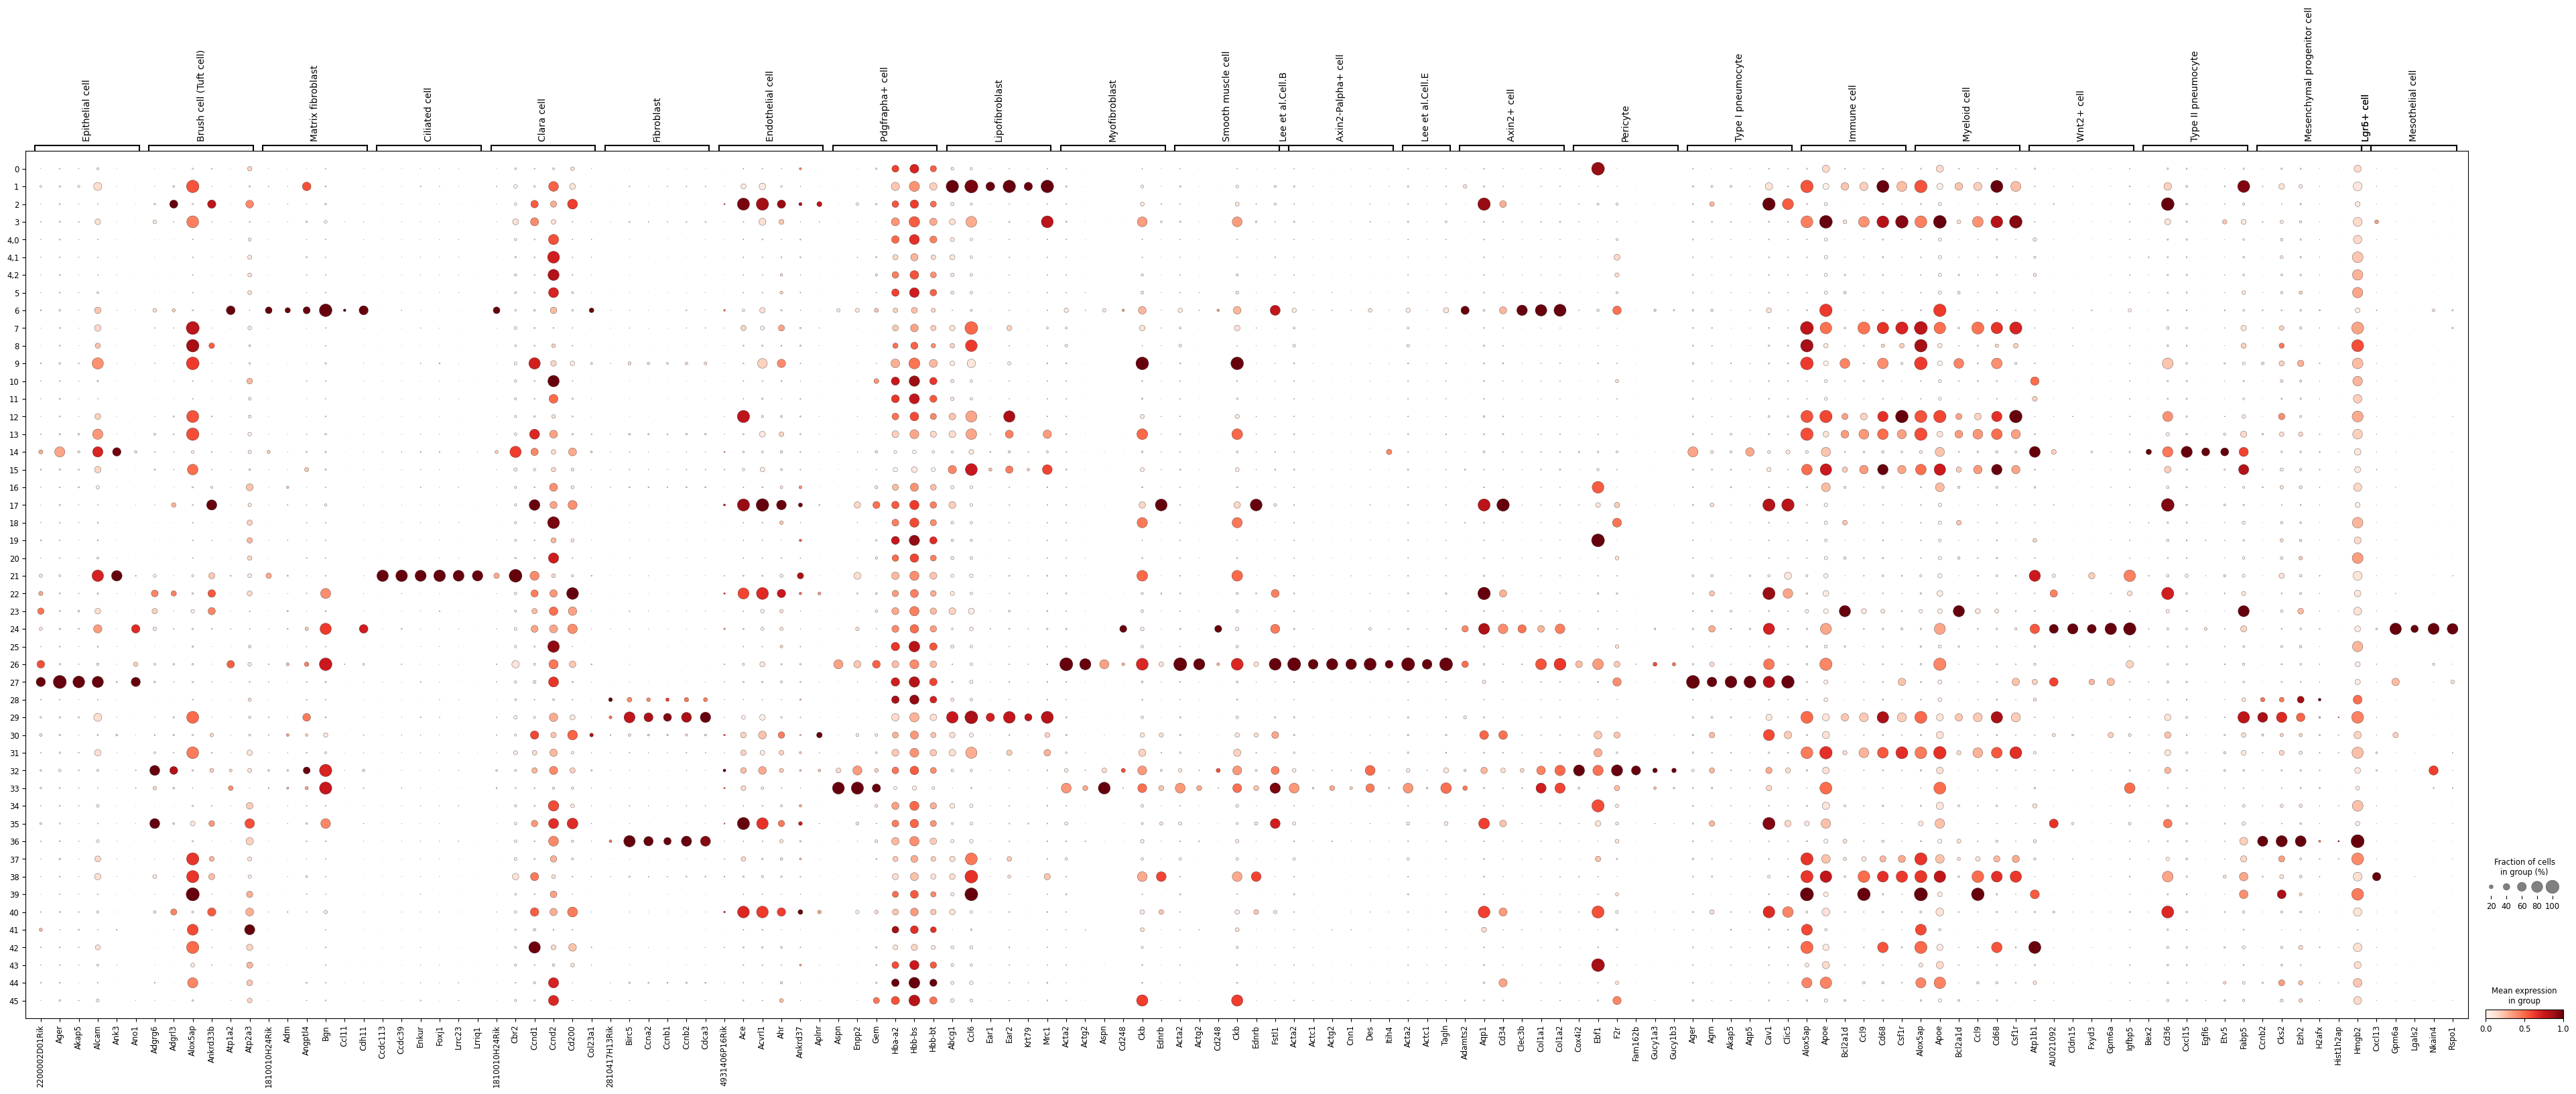

In [92]:
sc.pl.dotplot(adata_integrated, shortened_cell_marker_dict, groupby=["leiden_res1"], standard_scale="var" )

In [97]:
mapping_majority = dict(zip(adata_integrated.obs["leiden_res1"], adata_integrated.obs["majority_anno"]))

In [98]:
mapping_majority

{'6': 'Fibroblasts',
 '33': 'Peribronchial fibroblasts',
 '1': 'Alveolar macrophages',
 '9': 'Dendritic cells',
 '22': 'Endothelial',
 '24': 'Adventitial fibroblasts',
 '0': 'B-cells',
 '17': 'Endothelial',
 '16': 'B-cells',
 '2': 'Endothelial',
 '7': 'Monocytes',
 '42': 'Dendritic cells',
 '12': 'Monocytes',
 '10': 'NK cells',
 '25': 'T-cells',
 '11': 'T-cells',
 '14': 'AT1/2',
 '4,1': 'T-cells',
 '13': 'Dendritic cells',
 '15': 'Interstitial macrophages',
 '8': 'Neutrophils',
 '3': 'Interstitial macrophages',
 '31': 'Interstitial macrophages',
 '19': 'B-cells',
 '18': 'T-cells',
 '26': 'SMCs',
 '34': 'B-cells',
 '4,0': 'T-cells',
 '5': 'T-cells',
 '4,2': 'T-cells',
 '39': 'NK cells',
 '21': 'Transitioning epithelial',
 '32': 'SMCs',
 '29': 'Alveolar macrophages',
 '23': 'Dendritic cells',
 '20': 'T-cells',
 '35': 'Endothelial',
 '38': 'Interstitial macrophages',
 '37': 'Neutrophils',
 '45': 'T-cells',
 '40': 'Endothelial',
 '30': 'Endothelial',
 '44': 'NK cells',
 '36': 'T-cells',
 '

In [5]:
final_anno = {'6': 'Fibroblasts',
 '33': 'Peribronchial fibroblasts',
 '1': 'Alveolar macrophages',
 '9': 'Dendritic cells',
 '22': 'Endothelial',
 '24': 'Adventitial fibroblasts',# todo Wnt2+ cells, mesothelial cells 
 '0': 'B-cells',
 '17': 'Aerocytes',
 '16': 'B-cells',
 '2': 'Endothelial',
 '7': 'Classical Monocytes',
 '42': 'Dendritic cells',
 '12': 'Non-classical monocytes', # todo immune cells, myeloid cells, 
 '10': 'NK cells',
 '25': 'T-cells', #todo
 '11': 'Cd4 T-cells',
 '14': 'AT2',
 '4,1': 'Cd8 T-cells',
 '13': 'Dendritic cells', # todo myeloid, immune --> more detailed 
 '15': 'Interstitial macrophages',
 '8': 'Neutrophils',
 '3': 'Interstitial macrophages',
 '31': 'Interstitial macrophages', 
 '19': 'B-cells',
 '18': 'Cd4-/Cd8- T-cells',
 '26': 'SMCs',
 '34': 'B-cells',
 '4,0': 'Cd8 T-cells',
 '5': 'Cd4 T-cells',
 '4,2': 'Cd4-/Cd8- T-cells',
 '39': 'NK cells', # todo immune/ myeloid 
 '21': 'Transitioning epithelial',
 
 '32,0': 'Pericytes', # double check 
 '32,1': 'Myofibroblasts', 
 '32,2': 'Myofibroblasts',
 '32,3': 'B-cells',
 '32,4': 'T-cells',
 '32,5': 'Pericytes',
 
 '29': 'Alveolar macrophages',
 '23': 'Dendritic cells', # todo Immune cells check 
 '20': 'Cd8 T-cells',
 '35': 'Endothelial',
 '38': 'Interstitial macrophages', # todo immune myeloid double check 
 '37': 'Neutrophils',
 '45': 'T-cells', # todo 
 '40,0': 'Endothelial', # B cells + endothelial --> subcluster? 
 '40,1': 'Aerocytes', #
 '40,2': 'Endothelial', 
 '40,3': 'Endothelial', 
 '30': 'Endothelial',# 
 '44': 'NK cells',
 '36': 'Erythroid cells',
                     "27": "AT1",
 '43': 'B-cells',
 '28': 'Cd4+/Cd8+ T-cells',
     
              

'41': 'Platelets' #
} 

 


## Subclustering

In [9]:
# subcluster cluster 40 
sc.tl.leiden(adata_integrated, restrict_to= ("leiden_res1", ['40']),  key_added="leiden_res1", resolution=0.3)


In [13]:
# subcluster cluster 32 
sc.tl.leiden(adata_integrated, restrict_to= ("leiden_res1", ['32']),  key_added="leiden_res1", resolution=0.2)


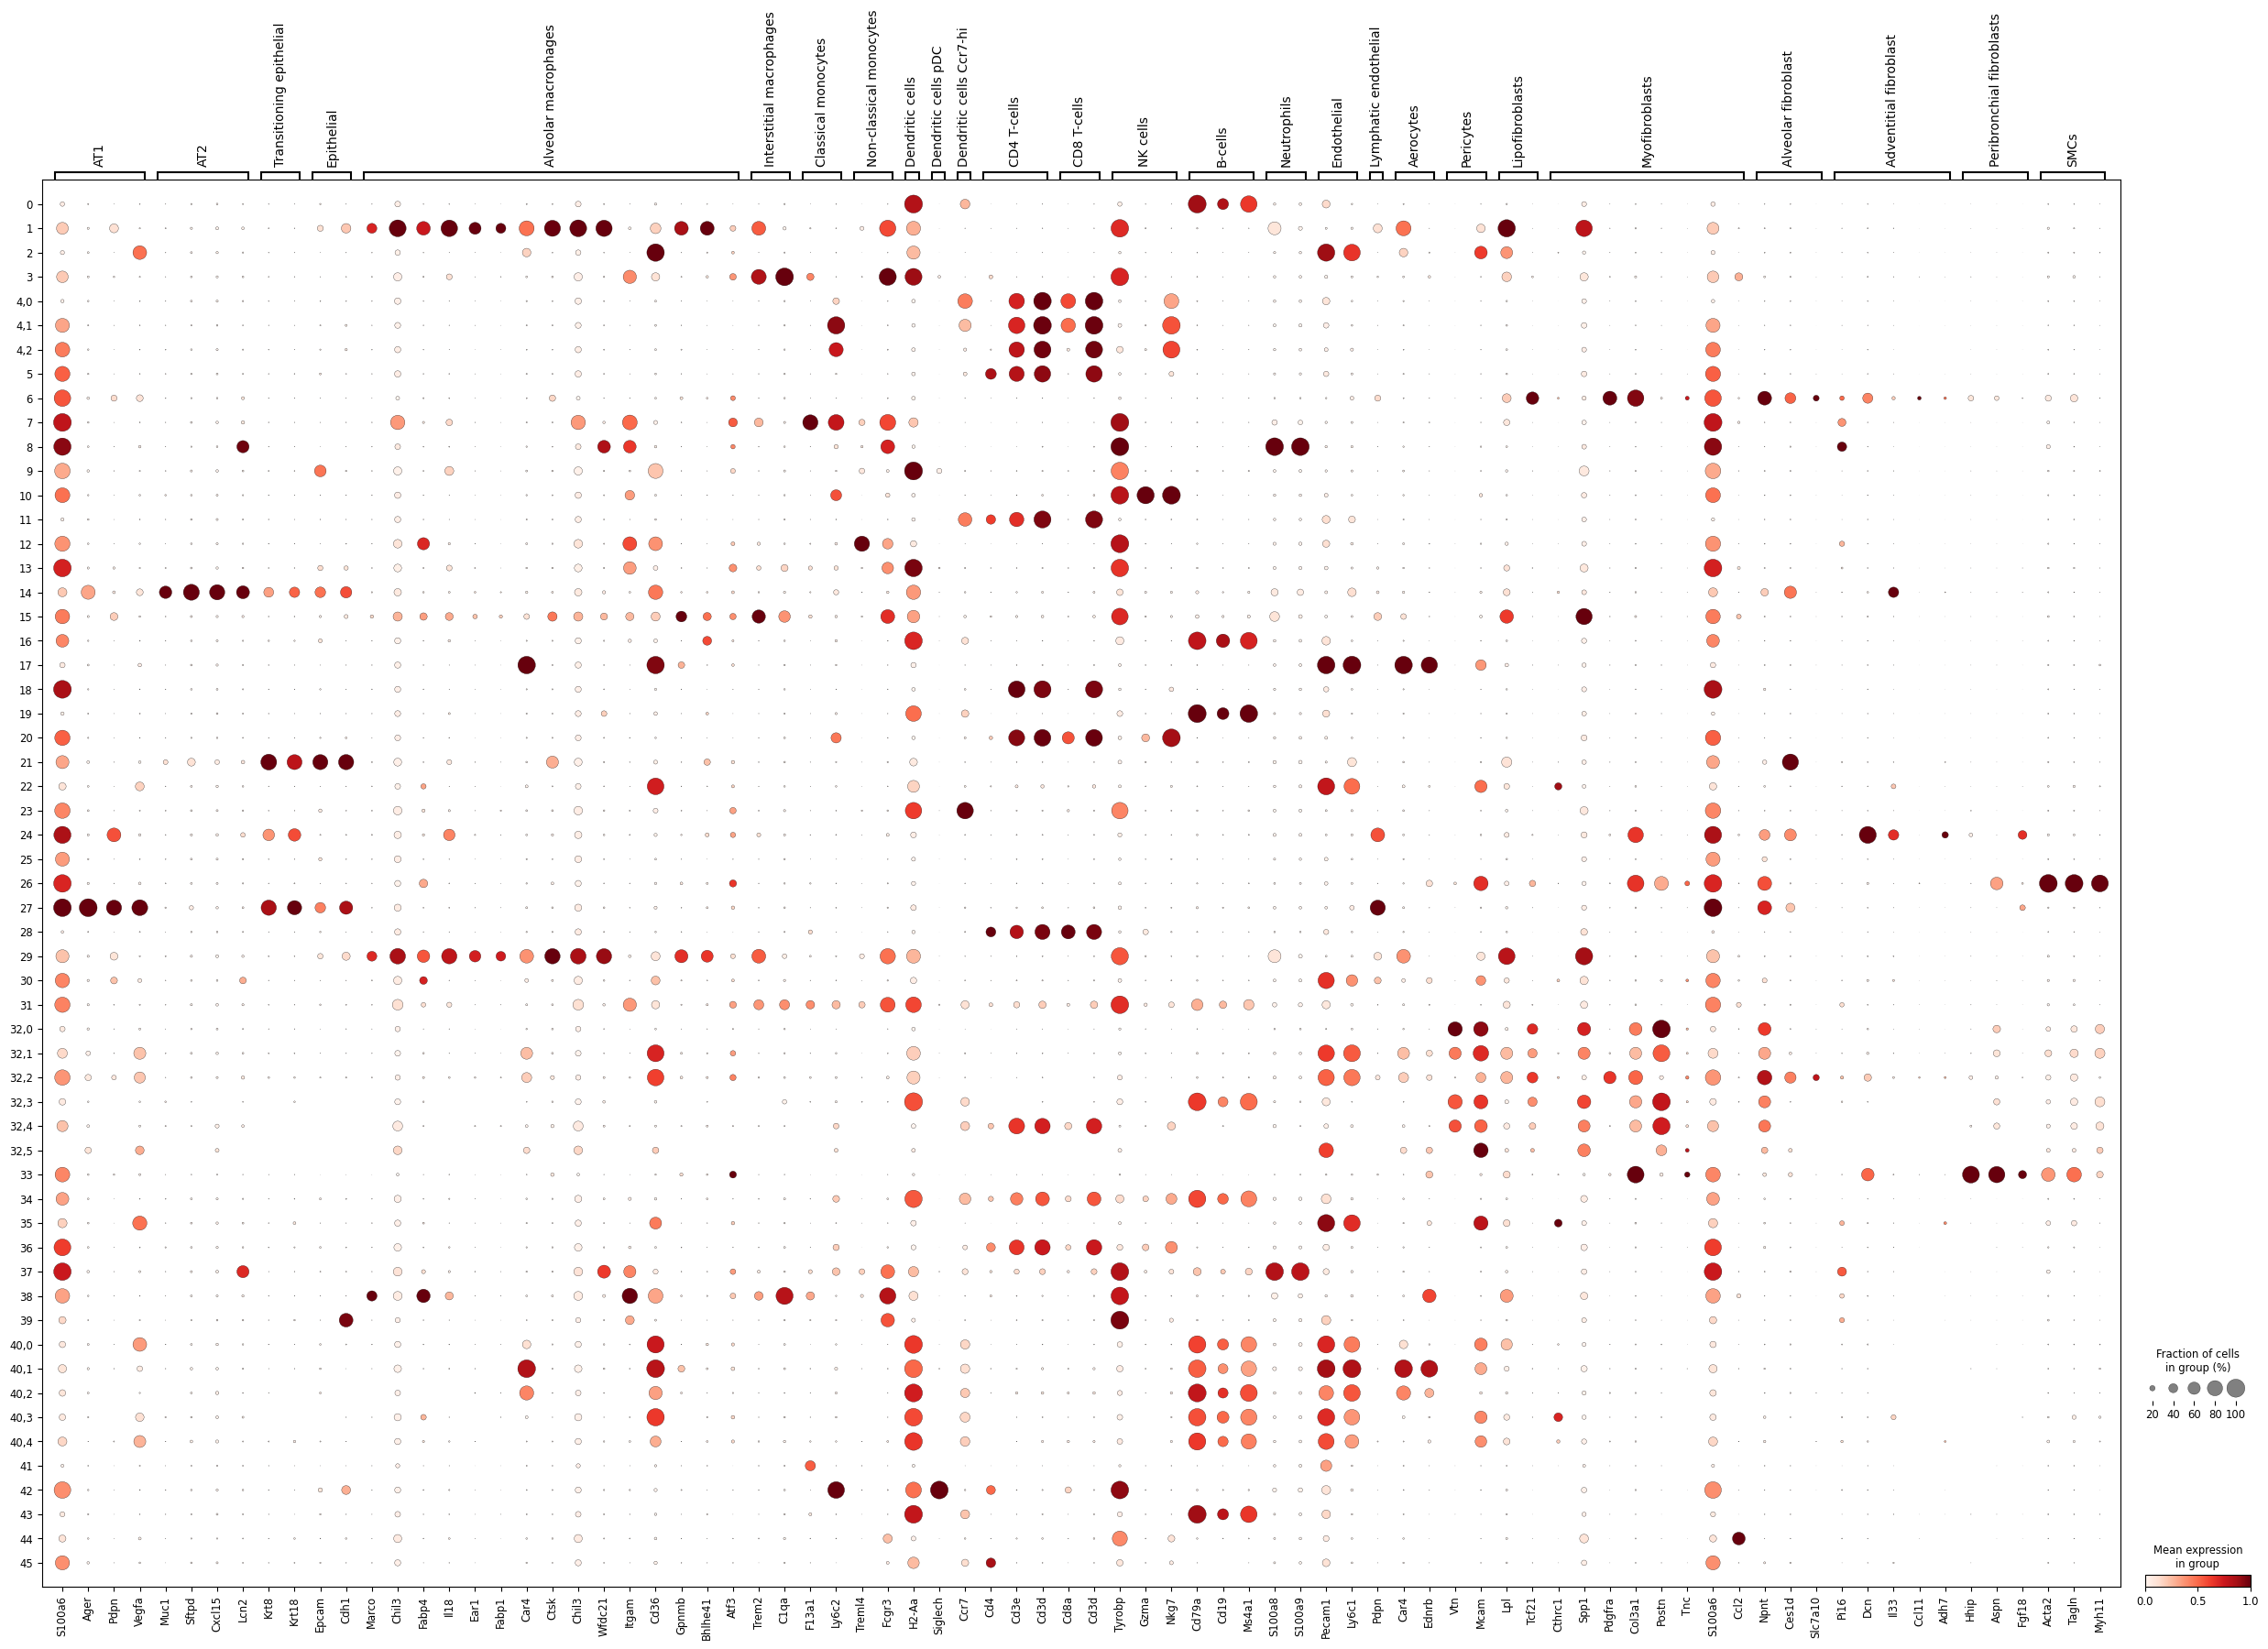

In [38]:
sc.pl.dotplot(adata_integrated, old_markers, groupby=["leiden_res1"], standard_scale="var" )

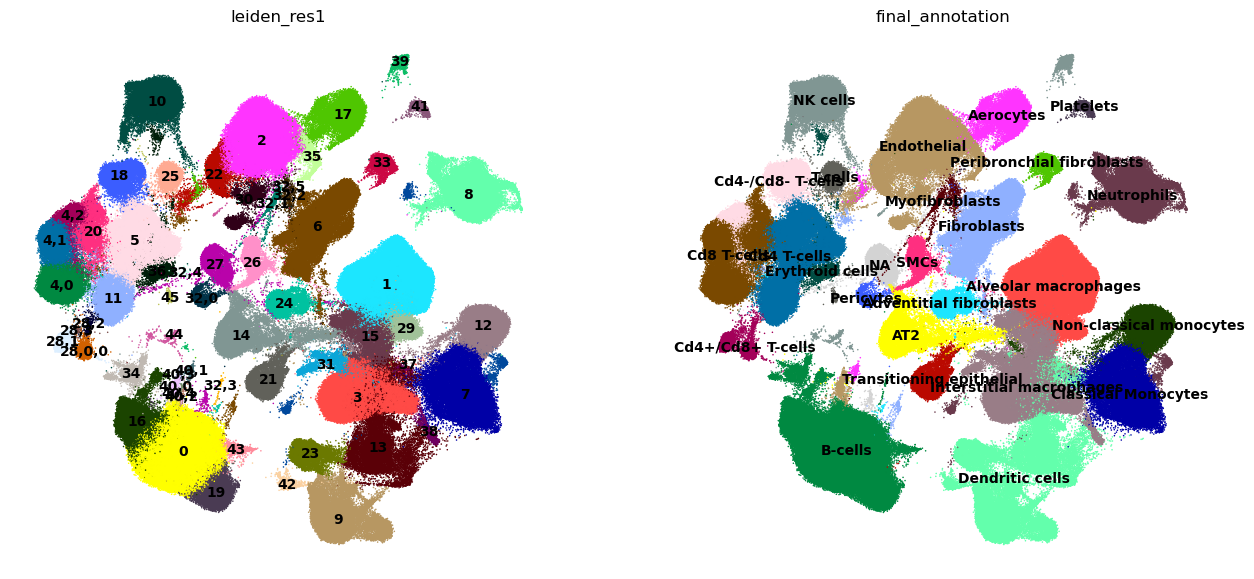

In [33]:
plt.rcParams['figure.figsize'] = (7, 7)
sc.pl.umap(
    adata_integrated,
    color=["leiden_res1", "final_annotation"],
    legend_loc="on data", 
     size=5, palette=sc.pl.palettes.default_102, frameon=False
)

# Rank gene groups 

In [ ]:
sc.tl.rank_genes_groups(
    adata_integrated, groupby="leiden_res1", method="wilcoxon", key_added="dea_leiden_res1"
)

In [6]:
sc.tl.filter_rank_genes_groups(
    adata_integrated,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key="dea_leiden_res1",
    key_added="dea_leiden_res1_filtered",
)

         Falling back to preprocessing with `sc.pp.pca` and default params.


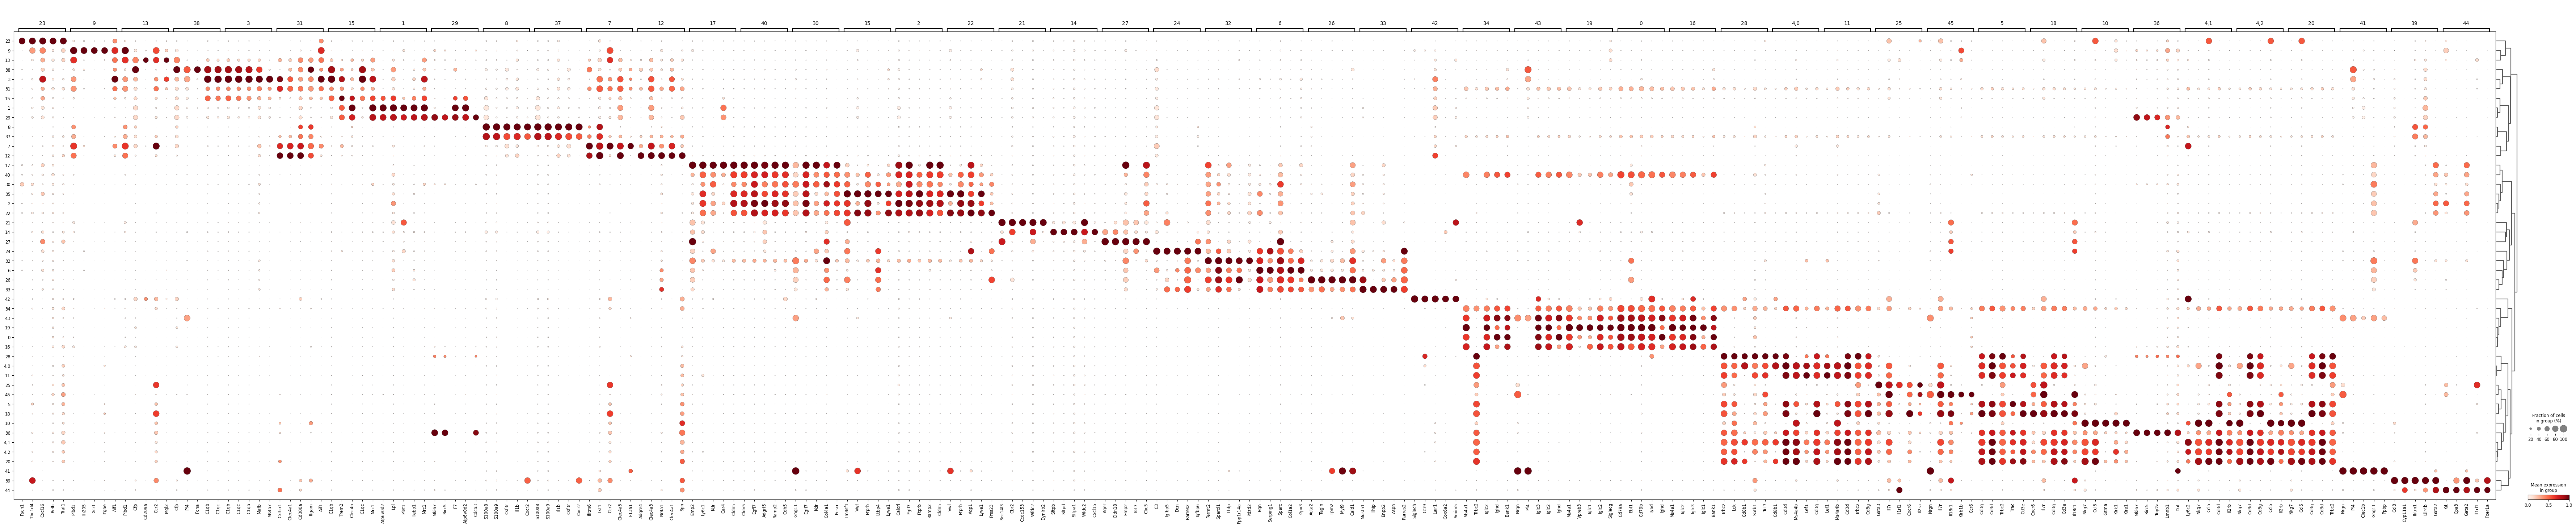

In [7]:
sc.pl.rank_genes_groups_dotplot(
    adata_integrated,
    groupby="leiden_res1",
    standard_scale="var",
    n_genes=5,
    key="dea_leiden_res1_filtered",
)

cluster...: --> use mouse cell atlas 
- 9: Dendritic cells 
- 24: Fibroblasts
- 12: Non-classical monocytes
- 25: T-cells
- 13: Dendritic cells 
- 31: 'Interstitial macrophages',
- 39: NK cells
- 23: Dendritic cells
- 38: Interstitial macrophages
- 40: Endothelial
- 30: Endothelial
- 36: Erythroid cells
- 41 tuft cells
- 45: T cells 

In [6]:
adata_integrated.obs["final_annotation"] = adata_integrated.obs.leiden_res1.map(final_anno).astype("category")

In [7]:
adata_integrated.write("/lustre/groups/ml01/workspace/daniel.michaela.masterpraktikum23/all_datasets_merged/final_anno_integrated.h5ad")